<a href="https://colab.research.google.com/github/GeneralGrube/JUGA_survey/blob/main/National_survey_training_cond.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analysisplan and Figures of "A national survey on preferred training conditions among trainers and trainees for board certification in gastroenterology."

*Umsetzung der Weiterbildung zum Facharzt für Gastroenterologie aus Sicht von Ausbilder:innen und Auszubildenden*


---
**Important Notice:**
 Most of this code was annotated in German. Should questions arise, please contact jakob.garbe@uk-halle.de

---

#### Table of Contents

1. Preperation and Helper-Functions
2. Data Cleaning
3. Data Aggregation and descriptive statistics
4. Figures
  1. Boxplots of Participants
  2. Likert-Scales
5. Misc

## Preperation and Helper-Functions / Vorbereitung und Helferfunktionen



folgende DFs werden im Verlauf erstellt und ausgelagert:


*   TZdf: Fragen zu Teilzeit
*   Semesterdf & WBdf: SD14 (Fachsemester) und SD15 (Weiterbildungsjahr) bei Studenten und Assistenzärzten
*   WBtxtdf: Weiterbildungsgespräch: Weitere Inhalte (offene Eingabe)



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

!mkdir output_data

### Helferfunktionen

für:
- Helferfunktionen für Datenbereinigung
- Likert Skalen
- Erstellung der Mastertables

In [2]:
#Helfer-Funktionen zur weiteren Verarbeitung vorlegen.
def convert_type(df,cols,type): #Datentyp einer Liste von Spalten in gewünschten Datentyp wandeln
  for col in cols:
    df[col] = surveydf[col].astype(type)
  return df

In [3]:
# Helper Function returning descriptive statistics of a series
def custom_stats(s):
  mean = s.mean()
  median = s.median()
  sd = s.std()
  q1 = s.quantile(0.25)
  q3 = s.quantile(0.75)
  iqr = q3 - q1

  return [mean,median,sd,iqr]



In [4]:
# Helferfunktion zum plotten der Likert Skalen
# 1. Spalte: Stufen der Likert Skala
# 2. und weitere Spalten: Antworten. 
# Ganzzahlen übergeben
def build_likert_df(los,titles,scale): #if 4digit scale code is passed, use this
  #Skala feststellen
  if type(scale) == str:
    scale_codes = {
      "4ade": ["stimme voll zu", "stimme zu", "stimme nicht zu", "stimme überhaupt nicht zu"],
      "4aen": ["strongly agree", "agree", "disagree", "strongly disagree"],
      "4pde": ["sehr wahrscheinlich", "wahrscheinlich", "unwahrscheinlich", "sehr unwahrscheinlich"],
      "4pen": ["very likely", "likely", "unlikely", "very unlikely"],
      "5ade": ["stimme voll zu", "stimme zu", "keine Meinung", "stimme nicht zu", "stimme überhaupt nicht zu"],
      "5aen": ["strongly agree", "agree", "no opinion", "disagree", "strongly disagree"],
      "5pde": ["sehr wahrscheinlich", "wahrscheinlich", "keine Meinung", "unwahrscheinlich", "sehr unwahrscheinlich"],
      "5pen": ["very likely", "likely", "no opinion", "unlikely", "very unlikely"],
      }
    if scale in scale_codes:
      scale = scale_codes[scale]
    else:
      raise ValueError("ungültiger Skalencode!")
  #df basteln
  df = pd.DataFrame(scale, columns=["likert"])
  for i,l in enumerate(los):
    df = df.join(pd.Series(l, name=titles[i]))
  for t in titles:
    df[t+"_%"]   = df[t]/sum(df[t])
  for t in titles:
    df[t+"_cum"] = df[t+"_%"].cumsum()
  return scale, df

def likert_arrange(df, titles,leftmin=0.05,rightmin=0.05):
  #check for # of steps
  no_steps = df.shape[0]
  #print("Anzahl Schritte: " + str(no_steps))
  center = (no_steps//2)
  if df.shape[0]%2 == 1: odd_factor=0.5
  else: odd_factor=0

  #buffer berechnen
  colcenterlist=[]
  leftbuffer = []
  rightbuffer = []
  offset = len(titles)+1
  
  for i,t in enumerate(titles):
    colcenterlist.append(df.loc[center,t+"_%"]*odd_factor + df.loc[center-1,t+"_cum"])
  
  for i in range(len(colcenterlist)):
    if colcenterlist[i] == max(colcenterlist):
      leftbuffer.append(leftmin)
    else:
      leftbuffer.append(max(colcenterlist) - colcenterlist[i] + leftmin)
    if colcenterlist[i] == min(colcenterlist):
      rightbuffer.append(rightmin)
    else:
      rightbuffer.append(colcenterlist[i] - min(colcenterlist) + rightmin)
  
  # update df
  titles_pct = [t + "_%" for t in titles]
  left_df = pd.DataFrame([leftbuffer], columns=titles_pct)
  right_df = pd.DataFrame([rightbuffer], columns=list(titles_pct))
  df = pd.concat([left_df,df,right_df], sort=False, ignore_index=True)
  for i,t in enumerate(titles):
    df[t+"_cum"]=df[t+"_%"].cumsum()
  
  return df, (max(colcenterlist)+leftmin), df.iloc[-1,-1]

def likert(los, titles, scale):
  scale, df = build_likert_df(los,titles,scale)
  df, centerline, plotmax  = likert_arrange(df, titles)
  
  titles_pct = [t + "_%" for t in titles]
  titles_cum = [t + "_cum" for t in titles]
  
  height= len(titles)*0.5
  fig, ax = plt.subplots(figsize=(8.5,height))
  y=np.arange(len(titles))
  ax.invert_yaxis()
  ax.xaxis.set_visible(False)
  ax.set_xlim(0, plotmax)
  category_colors = plt.get_cmap('coolwarm_r')(np.linspace(0.1, 0.9, len(scale)))

  ax.axvline(centerline, color="gray", zorder=10)

  # Plot stacked bars
  ax.barh(y, df.loc[0,titles_pct], height=0.8, color="w", zorder=2)

  for i in range(1,len(scale)+1):
    ax.barh(y, df.loc[i,titles_pct], left=df.loc[i-1,titles_cum], label=scale[i-1], height=0.8, color=category_colors[i-1], zorder=3) 

  # Balken mit % oder absoluten Zahlen versehen
  label_colors = ["black"]*len(scale) #Textlabel colors, no consideration of contrast yet.
  label_colors[0]="white"
  label_colors[-1]="white"

  for i in range(len(titles)): #row-wise annotation
    for j in range(1,len(scale)+1): 
      x = df.loc[j-1,titles_cum[i]]+(df.loc[j,titles_pct[i]]/2) #find plotting position 
      if int(np.around(df.loc[j,titles_pct[i]]*100)) > 3: #do not plot if not enough space
        ax.text(x, i, (str(int(np.around(df.loc[j,titles_pct[i]]*100)))+"%"), ha='center', va='center', color=label_colors[j-1], zorder=10)
      #if int(np.around(df.loc[j,titles_pct[i]]*100)) < 1: #Ausnahme: Balken <1%
       # ax.text(x, i, ("<1%"), ha='center', va='center', color=label_colors[j-1], zorder=10)

  ax.set_yticks(y)
  ax.set_yticklabels(titles)

  return fig, ax

In [5]:
# Helferfunktionen zur Erstellung der Mastertables
# Tabelle wird iterativ gefüllt
# mt_filldf ruft für jede Spalte (Subgruppe) mt_fillcol auf, die wiederum ruft für jede Varaible mt_fillvar auf.
def mt_fillvar(data, var, cond, steps):
  if cond == None:
    abs = data[var].value_counts().sort_index()
    pct = data[var].value_counts(normalize=True).sort_index()
  else:
    abs = data[var].loc[data[cond[0]]==cond[1]].value_counts().sort_index()
    pct = data[var].loc[data[cond[0]]==cond[1]].value_counts(normalize=True).sort_index()
  # mt index vorlegen
  index= []
  for i in range(1, steps+1):
    if i in abs.index:
      index.append(f"{var}_{i}")
  abs.index = index
  pct.index = index
  return abs, pct

def mt_fillcol(data, col, cond, var_list, steps_list):
  for i,var in enumerate(var_list):    
    abs, pct = mt_fillvar(data, var, cond, steps_list[i])
    for r in abs.index:
      mt_abs.loc[r,col] = abs.loc[r]
    for r in pct.index:
      mt_pct.loc[r,col] = pct.loc[r]
    mt_abs.loc["Total",col], mt_pct.loc["Total",col] = abs.sum(), np.round(abs.sum()/mt_abs.iloc[0,0], 4)#col totals   

def mt_filldf(data, col_list, cond_dict, var_list, steps_list):
  mt_abs.iloc[0,0]=data.shape[0]
  for col in col_list:
    mt_fillcol(data, col, cond_dict[col], var_list, steps_list)

### Datensatz laden

In [6]:
surveydf = pd.read_excel("https://github.com/GeneralGrube/JUGA_survey/blob/291df1a4d08e853a36eb1917b3662b994a7f7917/data_JuGa_final.xlsx?raw=true")

## Data Cleaning / Datenbereinigung

CASE          0
SERIAL      999
REF         999
QUESTNNR      0
MODE          0
           ... 
MAXPAGE       0
MISSING       0
MISSREL       0
TIME_RSI      0
DEG_TIME      0
Length: 71, dtype: int64


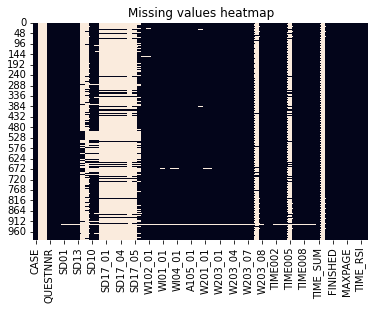

In [7]:
sns.heatmap(surveydf.isnull(), cbar = False).set_title("Missing values heatmap")
print(surveydf.isnull().sum())

### Unnütze Spalten und Zeilen mit Missings zensieren

In [8]:
#drop rows not containing data or containing missing data
surveydf.drop(labels=[0],axis=0, inplace=True)
missings = surveydf[surveydf["LASTPAGE"] != 10].index.tolist()
surveydf.drop(index=missings, inplace=True)
print(f"Zwei Einträge ({missings}) (CAVE: Index != Case) enthalten Missings und werden zensiert.")
#drop useless cols
surveydf.drop(columns=["SERIAL","REF","QUESTNNR","MODE","STARTED"], inplace=True)
useless = ["T102","TIME001","TIME002","TIME003","TIME004","TIME005","TIME006","TIME007","TIME008","TIME009","TIME010","TIME_SUM","MAILSENT","LASTDATA","FINISHED","Q_VIEWER","LASTPAGE","MAXPAGE","MISSING","MISSREL","TIME_RSI","DEG_TIME"]
surveydf.drop(columns=useless, inplace=True)

Zwei Einträge ([881, 929]) (CAVE: Index != Case) enthalten Missings und werden zensiert.


In [9]:
#Überprüfen, welche Datentypen angebracht sind. NaN per Definition dtype float.
col_int = ["CASE", "SD01", "SD02_01", "SD11", "SD13"]
surveydf = convert_type(surveydf, col_int, "int")
#surveydf.dtypes

In [10]:
print(surveydf.isnull().sum())

CASE          0
SD01          0
SD02_01       0
SD11          0
SD13          0
SD14        832
SD15        873
SD10        165
SD16        186
SD17        869
SD17_01     869
SD17_02     869
SD17_03     869
SD17_04     869
SD17_06     869
SD17_06a    969
SD17_05     869
SD18        316
W101_01       1
W102_01       4
R101_01       3
R102_01       3
WI01_01       4
WI02_01       0
WI03_01       2
WI04_01       2
A101_01       1
A104_01       1
A105_01       3
A102_01       1
A103_01       4
W201_01       3
W202_01       1
W203          0
W203_01       0
W203_02       0
W203_03       0
W203_04       0
W203_05       0
W203_06       0
W203_07       0
W203_09       0
W203_09a    942
W203_08       0
dtype: int64


### Bereinigung SD 13 (Position)

SD13 - Was ist Ihre derzeitige Position?

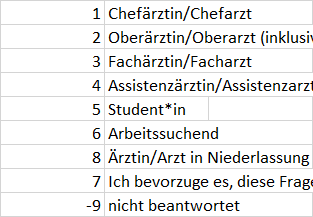

In [11]:
# 6 (n=3) und 7 (n=18) ex. 
jobless = surveydf[surveydf["SD13"] == 6].index.tolist()
surveydf.drop(index=jobless, inplace=True)
print(f"{len(jobless)} Einträge ({jobless}) (CAVE: Index != Case) enthalten Missings und werden zensiert.")
wontsay = surveydf[surveydf["SD13"] == 7].index.tolist()
surveydf.drop(index=wontsay, inplace=True)
print(f"{len(wontsay)} Einträge ({wontsay}) (CAVE: Index != Case) enthalten Missings und werden zensiert.")
print(f"Datensatz enthält {surveydf.shape[0]} auswertbare Zeilen.")

3 Einträge ([581, 872, 971]) (CAVE: Index != Case) enthalten Missings und werden zensiert.
18 Einträge ([82, 106, 134, 150, 167, 203, 324, 335, 338, 345, 366, 426, 820, 844, 878, 879, 880, 942]) (CAVE: Index != Case) enthalten Missings und werden zensiert.
Datensatz enthält 976 auswertbare Zeilen.


### Auslagerung Teilzeitfragen (SD17)

In [12]:
TZdf = surveydf.copy()
droplist = ["SD17","SD17_01","SD17_02","SD17_03","SD17_04","SD17_06","SD17_06a","SD17_05"]
surveydf.drop(columns=droplist, inplace=True)

droplist = ["SD14","SD15","SD16","W101_01","W102_01","R101_01","R102_01","WI01_01","WI02_01","WI03_01","WI04_01","A101_01","A104_01","A105_01","A102_01","A103_01","W201_01","W202_01","W203","W203_01","W203_02","W203_03","W203_04","W203_05","W203_06","W203_07","W203_09","W203_09a","W203_08"]
TZdf.drop(columns=droplist, inplace=True)

### Löschen der Missing in Fragen W101 bis W202

In [13]:
qlist = ["W101_01","W102_01","R101_01","R102_01","WI01_01","WI02_01","WI03_01","WI04_01","A101_01","A104_01","A105_01","A102_01","A103_01","W201_01","W202_01"]
print(surveydf[qlist].isnull().sum())
missingcnt = 0
for q in qlist:
  print(q)
  missings = surveydf[surveydf[q].isnull()].index.tolist()
  missingcnt = missingcnt + len(missings)
  surveydf.drop(index=missings, inplace=True)
  print(f"{len(missings)} Eintrag/Einträge ({missings}) (CAVE: Index != Case) enthalten Missings und werden zensiert.")

print(f"Insgesamt wurden in dem Frageblock {missingcnt} Zeilen zensiert.")
print(f"Datensatz enthält {surveydf.shape[0]} auswertbare Zeilen.")

W101_01    1
W102_01    4
R101_01    3
R102_01    3
WI01_01    4
WI02_01    0
WI03_01    2
WI04_01    2
A101_01    1
A104_01    1
A105_01    3
A102_01    1
A103_01    4
W201_01    3
W202_01    1
dtype: int64
W101_01
1 Eintrag/Einträge ([156]) (CAVE: Index != Case) enthalten Missings und werden zensiert.
W102_01
3 Eintrag/Einträge ([28, 597, 645]) (CAVE: Index != Case) enthalten Missings und werden zensiert.
R101_01
3 Eintrag/Einträge ([457, 545, 951]) (CAVE: Index != Case) enthalten Missings und werden zensiert.
R102_01
1 Eintrag/Einträge ([554]) (CAVE: Index != Case) enthalten Missings und werden zensiert.
WI01_01
3 Eintrag/Einträge ([255, 672, 912]) (CAVE: Index != Case) enthalten Missings und werden zensiert.
WI02_01
0 Eintrag/Einträge ([]) (CAVE: Index != Case) enthalten Missings und werden zensiert.
WI03_01
0 Eintrag/Einträge ([]) (CAVE: Index != Case) enthalten Missings und werden zensiert.
WI04_01
0 Eintrag/Einträge ([]) (CAVE: Index != Case) enthalten Missings und werden zensie

### SD 14 (Fachsemester) und SD 15 (Weiterbildungsjahr) filtern und entfernen.

count    158.000000
mean       8.272152
std        2.438149
min        1.000000
25%        6.000000
50%        8.000000
75%       10.000000
max       12.000000
Name: SD14, dtype: float64


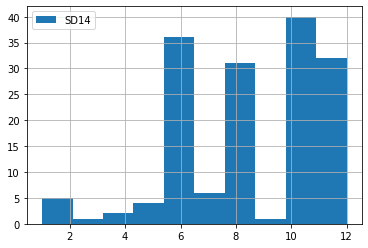

In [14]:
Semesterdf = surveydf[["CASE", "SD14"]].copy()
Semesterdf.dropna(inplace=True)
Semesterdf["SD14"] = Semesterdf["SD14"].astype(int)
print(Semesterdf["SD14"].describe())
Semesterdf["SD14"].hist(legend=True)

count    123.000000
mean       3.593496
std        1.754794
min        1.000000
25%        2.000000
50%        4.000000
75%        5.000000
max        7.000000
Name: SD15, dtype: float64


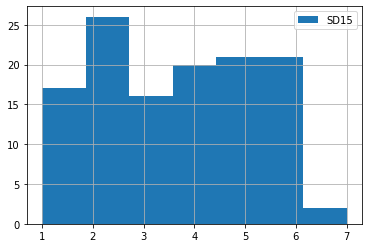

In [15]:
WBdf = surveydf[["CASE", "SD15"]].copy()
WBdf.dropna(inplace=True)
WBdf["SD15"] = WBdf["SD15"].astype(int)
print(WBdf["SD15"].describe())
WBdf["SD15"].hist(bins=7, legend=True)

In [16]:
surveydf.drop(columns=["SD14","SD15"], inplace=True)

### Freitextantworten auslagern.

In [17]:
WBtxtdf = surveydf[["CASE","W203_09a"]].copy()
WBtxtdf.dropna(inplace=True)
WBtxtdf.to_excel("output_data/Freitexte_Weiterbildungsgespräch.xlsx")
surveydf.drop(columns=["W203_09a"], inplace=True)

### Arbeitsstelle recodieren
SD18 (Arbeitsstelle) ist missing bei SD13 (Position) = ambulant

In [18]:
surveydf.SD18.loc[surveydf.SD13 == 8] = 4

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### Median Split für Alter

In [19]:
# Median Split für Variable Alter
median = surveydf.SD02_01.loc[surveydf.SD02_01 >= 18].median()
surveydf["Age_cut"] = pd.cut(surveydf.SD02_01,bins=[0,18,median,surveydf.SD02_01.max()], labels=[0,1,2]) 
median

42.0

CASE         0
SD01         0
SD02_01      0
SD11         0
SD13         0
SD10       158
SD16       158
SD18       158
W101_01      0
W102_01      0
R101_01      0
R102_01      0
WI01_01      0
WI02_01      0
WI03_01      0
WI04_01      0
A101_01      0
A104_01      0
A105_01      0
A102_01      0
A103_01      0
W201_01      0
W202_01      0
W203         0
W203_01      0
W203_02      0
W203_03      0
W203_04      0
W203_05      0
W203_06      0
W203_07      0
W203_09      0
W203_08      0
Age_cut      0
dtype: int64


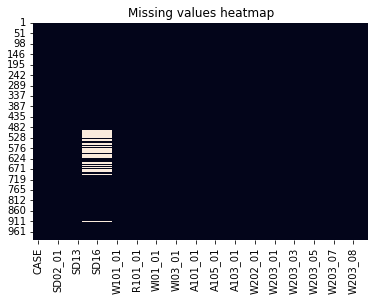

In [20]:
sns.heatmap(surveydf.isnull(), cbar = False).set_title("Missing values heatmap")
print(surveydf.isnull().sum())

## Data Aggregation and descriptive Statistics

---
**Aggregated Data Output:**
Aggregated data is stored in two tables in the "output_data" folder:
- mastertable_abs.xlsx contains the overall absolut responses and for each subgroup.
- mastertable_pct.xlsx contains the same data expressed in percent.

---

### Descriptive Statistics for Paper

In [21]:
#Teilzeit und Alter
parttime = surveydf[surveydf["SD16"]==1].shape[0]
w_parttime = surveydf[(surveydf["SD01"]==1) & (surveydf["SD16"]==1)].shape[0]
frac = w_parttime/parttime
print(f"{np.round(frac*100,1)}% of part-time workers ({parttime}) are women ({w_parttime}).")

55.6% of part-time workers (117) are women (65).


In [22]:
#Age structure by position
stats = custom_stats(surveydf.SD02_01[surveydf["SD13"]==1])
print(f"Dept. Heads:\nMittel: {np.round(stats[0],1)}, Median: {np.round(stats[1],1)}, SD: {np.round(stats[2],2)}, IQR: {np.round(stats[3],0)}.\n")

stats = custom_stats(surveydf.SD02_01[surveydf["SD13"]==2])
print(f"Senior Physicians:\nMittel: {np.round(stats[0],1)}, Median: {np.round(stats[1],1)}, SD: {np.round(stats[2],2)}, IQR: {np.round(stats[3],0)}.\n")

stats = custom_stats(surveydf.SD02_01[surveydf["SD13"]==3])
print(f"Board Cert. Physicians:\nMittel: {np.round(stats[0],1)}, Median: {np.round(stats[1],1)}, SD: {np.round(stats[2],2)}, IQR: {np.round(stats[3],0)}.\n")

stats = custom_stats(surveydf.SD02_01[surveydf["SD13"]==4])
print(f"Residents:\nMittel: {np.round(stats[0],1)}, Median: {np.round(stats[1],1)}, SD: {np.round(stats[2],2)}, IQR: {np.round(stats[3],0)}.\n")

stats = custom_stats(surveydf.SD02_01[surveydf["SD13"]==5])
print(f"Students:\nMittel: {np.round(stats[0],1)}, Median: {np.round(stats[1],1)}, SD: {np.round(stats[2],2)}, IQR: {np.round(stats[3],0)}.\n")

stats = custom_stats(surveydf.SD02_01[surveydf["SD13"]==8])
print(f"Outpatient Physicians:\nMittel: {np.round(stats[0],1)}, Median: {np.round(stats[1],1)}, SD: {np.round(stats[2],2)}, IQR: {np.round(stats[3],0)}.\n")


Dept. Heads:
Mittel: 51.0, Median: 54.0, SD: 15.91, IQR: 10.0.

Senior Physicians:
Mittel: 43.1, Median: 43.0, SD: 13.34, IQR: 15.0.

Board Cert. Physicians:
Mittel: 42.5, Median: 37.0, SD: 14.34, IQR: 20.0.

Residents:
Mittel: 30.5, Median: 30.0, SD: 4.35, IQR: 5.0.

Students:
Mittel: 24.3, Median: 24.0, SD: 5.54, IQR: 4.0.

Outpatient Physicians:
Mittel: 52.4, Median: 54.0, SD: 12.5, IQR: 10.0.



In [23]:
#Child status/Care work
carework = surveydf[surveydf["SD11"]==1].shape[0]
print(f"{carework} ({np.round(carework/surveydf.shape[0]*100,1)}%) care for children.")

408 (42.6%) care for children.


In [24]:
#Contents of Yearly Feedback
print("Research as a topic in yearly feedbacks:\nCoding: 1=not of interest, 2=of interest")

print("\nOverall:")
s = surveydf.W203_05.value_counts()
print(f"{s[2]} of {s.sum()} ({np.round(s[2]/s.sum()*100,1)}%) are interested in reasearch as a topic in yearly feedback.")

print("\nResidents only:")
s = surveydf.W203_05[(surveydf["SD13"]==4)].value_counts()
print(f"{s[2]} of {s.sum()} ({np.round(s[2]/s.sum()*100,1)}%) are interested in reasearch as a topic in yearly feedback.")

print("\nUniversity Hospital personnel only:")
s = surveydf.W203_05[(surveydf["SD18"]==1)].value_counts()
print(f"{s[2]} of {s.sum()} ({np.round(s[2]/s.sum()*100,1)}%) are interested in reasearch as a topic in yearly feedback.")

print("\nSubgroup Residents in University Hospitals:")
s = surveydf.W203_05[(surveydf["SD13"]==4) & (surveydf["SD18"]==1)].value_counts()
print(f"{s[2]} of {s.sum()} ({np.round(s[2]/s.sum()*100,1)}%) are interested in reasearch as a topic in yearly feedback.")

Research as a topic in yearly feedbacks:
Coding: 1=not of interest, 2=of interest

Overall:
410 of 958 (42.8%) are interested in reasearch as a topic in yearly feedback.

Residents only:
77 of 123 (62.6%) are interested in reasearch as a topic in yearly feedback.

University Hospital personnel only:
142 of 195 (72.8%) are interested in reasearch as a topic in yearly feedback.

Subgroup Residents in University Hospitals:
60 of 84 (71.4%) are interested in reasearch as a topic in yearly feedback.


In [25]:
#Contents of Yearly Feedback II
print("Commitment besides regular patient care as a topic in yearly feedbacks:\nCoding: 1=not of interest, 2=of interest")

print("\nOverall:")
s = surveydf.W203_06.value_counts()
print(f"{s[2]} of {s.sum()} ({np.round(s[2]/s.sum()*100,1)}%) are interested in committment as a topic in yearly feedback.")

print("\nResidents only:")
s = surveydf.W203_06[(surveydf["SD13"]==4)].value_counts()
print(f"{s[2]} of {s.sum()} ({np.round(s[2]/s.sum()*100,1)}%) are interested in committment as a topic in yearly feedback.")

print("\nDept. Heads only:")
s = surveydf.W203_06[(surveydf["SD13"]==1)].value_counts()
print(f"{s[2]} of {s.sum()} ({np.round(s[2]/s.sum()*100,1)}%) are interested in committment as a topic in yearly feedback.")

print("\nUniversity Hospital personnel only:")
s = surveydf.W203_06[(surveydf["SD18"]==1)].value_counts()
print(f"{s[2]} of {s.sum()} ({np.round(s[2]/s.sum()*100,1)}%) are interested in committment as a topic in yearly feedback.")

print("\nSubgroup Residents in University Hospitals:")
s = surveydf.W203_06[(surveydf["SD13"]==4) & (surveydf["SD18"]==1)].value_counts()
print(f"{s[2]} of {s.sum()} ({np.round(s[2]/s.sum()*100,1)}%) are interested in committment as a topic in yearly feedback.")

print("\nSubgroup Dept. Heads in University Hospitals:")
s = surveydf.W203_06[(surveydf["SD13"]==1) & (surveydf["SD18"]==1)].value_counts()
print(f"{s[2]} of {s.sum()} ({np.round(s[2]/s.sum()*100,1)}%) are interested in committment as a topic in yearly feedback.")

Commitment besides regular patient care as a topic in yearly feedbacks:
Coding: 1=not of interest, 2=of interest

Overall:
464 of 958 (48.4%) are interested in committment as a topic in yearly feedback.

Residents only:
68 of 123 (55.3%) are interested in committment as a topic in yearly feedback.

Dept. Heads only:
94 of 158 (59.5%) are interested in committment as a topic in yearly feedback.

University Hospital personnel only:
118 of 195 (60.5%) are interested in committment as a topic in yearly feedback.

Subgroup Residents in University Hospitals:
49 of 84 (58.3%) are interested in committment as a topic in yearly feedback.

Subgroup Dept. Heads in University Hospitals:
9 of 18 (50.0%) are interested in committment as a topic in yearly feedback.


In [26]:
#Age, Sex and Research
#A103_01
#"A_<42": ("Age_cut", 1),
#"A_>=42": ("Age_cut", 2),
statsdf = surveydf.copy()

statsdf.drop(statsdf[statsdf.SD01 > 2].index, inplace=True) #drop wontsay and diverse
#statsdf.drop(statsdf[statsdf["Age_cut"] < 1].index, inplace=True) #Age_cut <18

pivot = statsdf.pivot_table(index="A103_01", columns=["Age_cut","SD01"], aggfunc={'A103_01': 'count',})
pivot

A103_01                     
Age_cut       0       1       2     
SD01          1  2    1   2   1    2
A103_01                             
1             4  4   72  52  12   38
2             7  5  131  79  33  108
3             2  6   50  39  19  146
4             1  6   19  19  13   77

In [27]:
#Age, Sex and Research and parttime
#A103_01

statsdf.drop(statsdf[statsdf.SD16 > 2].index, inplace=True) #drop wontsay

pivot = statsdf.pivot_table(index="A103_01", columns=["SD16","SD01"], aggfunc={'A103_01': 'count',})
pivot

A103_01             
SD16          1       2     
SD01          1   2   1    2
A103_01                     
1             8   6  42   68
2            33  18  80  153
3            19  16  34  170
4             5  12  25   89

In [28]:
print(WBdf.SD15.value_counts().sort_index())
print(WBdf.SD15.value_counts().sum())

1    17
2    26
3    16
4    20
5    21
6    21
7     2
Name: SD15, dtype: int64
123


### Mastertable

In [29]:
rows = ['W101_01', 'W102_01', 'R101_01', 'R102_01', 'WI01_01', 'WI02_01',
       'WI03_01', 'WI04_01', 'A101_01', 'A104_01', 'A105_01', 'A102_01',
       'A103_01', 'W201_01', 'W202_01', 'W203_01', 'W203_02',
       'W203_03', 'W203_04', 'W203_05', 'W203_06', 'W203_07'] #W203 ist nur Anzahl der Antworten, W203_08 ist quatsch und W203_09 Freitext
multiplier = [4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,2,2,2,2,2,2,2]
ext_rows = []

for i,r in enumerate(rows):
  for j in range(1,multiplier[i]+1):
    ext_rows.append(f"{r}_{j}")
ext_rows= ["Total"]+ext_rows

In [30]:
cols = ["Total", "G_w", "G_m", "G_d", "G_oA", "A_<42", "A_>=42", "Child_Y", "Child_N", "P_Chef", "P_OA", "P_FA", "P_Assi", "P_Stud", 
        "P_MVZ", "C_Uni", "C_Max", "C_Grund", "C_Amb", "Vollzeit", "Teilzeit"]
cond_dict = {
    "Total": None,
    "G_w": ("SD01", 1),
    "G_m": ("SD01", 2),
    "G_d": ("SD01", 3),
    "G_oA": ("SD01", 4),
    "A_<42": ("Age_cut", 1),
    "A_>=42": ("Age_cut", 2), 
    "Child_Y": ("SD11",1),
    "Child_N": ("SD11", 2), 
    "P_Chef": ("SD13", 1),
    "P_OA": ("SD13", 2), 
    "P_FA": ("SD13", 3), 
    "P_Assi": ("SD13", 4), 
    "P_Stud": ("SD13", 5), 
    "P_MVZ": ("SD13", 8), 
    "C_Uni": ("SD18", 1), 
    "C_Max": ("SD18", 2), 
    "C_Grund": ("SD18", 3), 
    "C_Amb": ("SD18", 4),
    "Vollzeit": ("SD16", 2),
    "Teilzeit": ("SD16", 1)
}

mt_abs = pd.DataFrame(data=None, columns=cols, index=ext_rows)
mt_pct = pd.DataFrame(data=None, columns=cols, index=ext_rows)

In [31]:
mt_filldf(surveydf, cols, cond_dict, rows, multiplier)
mt_abs

,Total,G_w,G_m,G_d,G_oA,A_<42,A_>=42,Child_Y,Child_N,P_Chef,...,P_FA,P_Assi,P_Stud,P_MVZ,C_Uni,C_Max,C_Grund,C_Amb,Vollzeit,Teilzeit
Total,958,363,579,3,13,465,452,408,540,158,...,100,123,158,128,195,154,274,166,672,117
W101_01_1,599,252,339,2,6,334,240,251,344,84,...,63,94,106,61,129,101,177,78,407,80
W101_01_2,238,83,151,1,3,95,133,101,135,49,...,26,20,40,35,46,36,63,51,170,26
W101_01_3,75,20,51,NaN,4,25,46,33,41,17,...,10,5,10,17,12,9,22,21,56,7
W101_01_4,46,8,38,NaN,NaN,11,33,23,20,8,...,1,4,2,15,8,8,12,16,39,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W203_05_2,410,167,233,1,9,234,159,161,247,63,...,42,77,89,42,142,50,63,60,278,37
W203_06_1,494,192,295,1,6,242,226,206,283,64,...,53,55,91,75,77,85,142,93,332,63
W203_06_2,464,171,284,2,7,223,226,202,257,94,...,47,68,67,53,118,69,132,73,340,54
W203_07_1,313,121,186,1,5,173,134,136,174,26,...,30,49,64,50,71,46,64,61,204,42


In [32]:
export_cols = ["Total", "weiblich", "männlich", "divers", "ohne Angabe", "<42", ">=42", "ja", "nein", "Chefarzt", "Oberarzt", 
               "Facharzt", "Assist", "Student", "Praxis", "Universität", "Maximimalversorger", "Grundversorger", "ambulant", "Vollzeit", "Teilzeit"]

def create_dict(cols, export_cols):
  dict = {}
  for i, col in enumerate(cols):
    dict[col] = export_cols[i]
  return dict

export_dict = create_dict(cols, export_cols)

export_abs, export_pct = mt_abs.copy(), mt_pct.copy()
export_abs.rename(columns=export_dict, inplace=True)
export_pct.rename(columns=export_dict, inplace=True)

export_abs.to_excel("output_data/mastertable_abs.xlsx")
export_pct.to_excel("output_data/mastertable_pct.xlsx")



## Figures

### Boxplots of Study Participants

Plots a Boxplot of Age of Respondents stratified by Position and Sex.

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


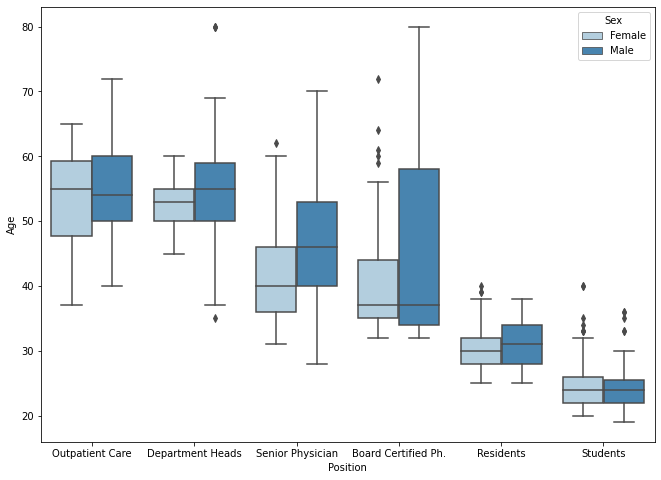

Altersangaben < 18 Jahren, sowie Geschlechtsangaben divers und enthaltung wurden zensiert


In [33]:
title= "Fig1"
fmtlist=[".png",".svg"] 

boxplotdf = surveydf.copy()

boxplotdf.SD02_01.loc[boxplotdf.SD02_01 < 18] = np.nan
boxplotdf.SD01.loc[boxplotdf.SD01 == 4] = np.nan
boxplotdf.SD01.loc[boxplotdf.SD01 == 3] = np.nan
fig, ax = plt.subplots(figsize=(11,8))
ax = sns.boxplot(x="SD13", y="SD02_01", hue="SD01",data=boxplotdf, showmeans=False, palette="Blues", order=[8,1,2,3,4,5])
ax.set_ylabel("Age")
ax.set_xlabel("Position")
ax.set_xticklabels(["Outpatient Care","Department Heads","Senior Physician","Board Certified Ph.","Residents","Students"])

ax.legend(title="Sex")
ax.legend_.texts[0].set_text("Female")
ax.legend_.texts[1].set_text("Male")

for fmt in fmtlist:
  plt.savefig("output_data/"+title+fmt)

plt.show()
print("Altersangaben < 18 Jahren, sowie Geschlechtsangaben divers und enthaltung wurden zensiert")


### Likert-Skalen für Gesamt und Subgruppen

#### Question Texts, Labels and Coding Information

In [62]:
# Questions Texts and Labels for an almost hassle-free contruction of figures with combined subgroups.

q_list = ["W101_01","W102_01","R101_01","R102_01","WI01_01","WI02_01","WI03_01","WI04_01","A101_01","A102_01","A103_01","A104_01",
          "A105_01","W201_01","W202_01"]

q_long2_de = ["Klinikinterne Weiterbildungsangebote sollten ... stattfinden.",
	"Externe Weiterbildungsangebote sollten durch ... bezahlt werden.",
	"Rotationen (ZNA, ITS, Ambulanzen etc.) sollten ... folgen.",
	"Die Rotationsreihenfolge sollte sich aus ... ergeben.",
	"Vor den ersten Schritten in der Sonographie und Endoskopie\nsollte ... eine Schulung ermöglicht werden.",
	"Die Ausbildung in der Sonographie und Endoskopie sollte ... erfolgen.",
	"Zu Beginn der Ausbildung in Funktionsabteilungen sollte\nein Supervisor ... im Untersuchungsraum anwesend sein.",
	"Das Erlernen fortgeschrittener Endoskopietechniken gehört in ... .",
	"Die Verantwortung in der Patientenversorgung obliegt ... .",
	"Der Arbeitstag einr/s Weiterbildungsassistent*in sollte ... strukturiert werden.",
	"Eigene Forschung sollte im Dienstplan ... .",
	"Teilzeittätigkeit darf ... in der Weiterbildung führen.",
  "Teilzeittätigkeit in der Weiterbildung … in allen Tätigkeitsbereichen\nermöglicht werden, wenn Kolleg*innen dadurch zusätzlich belastet werden.",
	"Die Weiterbildung ist qualitativ hochwertiger an ... Institution(en).",
	"Eine gute Weiterbildung funktioniert in der Regel ... Überstunden."]

q_long2_en= ["The institution's own continuing education should occur…",
	"External continuing education should be paid…",
	"Rotations (specializations, emergency department, intensive care unit,\noutpatient clinics, functional diagnostics) should follow…",
	"Rotation order in residency should be based on…",
	"Before the first steps in ultrasound or endoscopy\nresidents should receive training…",
	"Training in ultrasound and endoscopy should…",
	"The supervisor for the resident in training for endoscopy or ultrasound should…",
	"Training for independent execution of advanced endoscopy techniques\n(ERCP, PTBD) should be part of the training for…",
	"Responsibility for patient care is incumbent upon…",
	"The work day of a resident should…",
	"On the duty roster, own research should…",
	"Part-time work … lead to disadvantages in training.",
	"Part-time working in residency … be made possible in all areas of activity,\n(even) if colleagues are additionally burdened.",
	"Quality of residency training is higher at…",
	"Usually, good residency training… without overtime."]

q_scale_en = [["during duty hours.", "after duty hours."],
  ["by the residents.", "through the institution's internal training budget."],
	["a fixed curriculum.","a flexible course."],
	["individual performance and commitment.", "seniority."],
	["at their institution.", "at an external institution through an exemption/leave."],
	["take place parallel to clinical training on own patients.", "follow fixed rotations."],
	["initially be present in the examination room.","be consulted only if needed."],
	["certification in gastroenterology.", "a new additional designation ‘interventional endoscopy’."],
	["the senior physician.", "the resident."],
	["be structured independently.", "be structured by the senior physician."],
	["be reflected completely.","not be considered."],
	["must not","may"],
	["should","should not"],
	["a single institution.","multiple institutions."],
	["works","does not work"]]

q_scale_de = [["während der Dienstzeit","nach der Dienstzeit"],
  ["Weiterbildungsassistent*innen","ein klinikinternes Budget"], 
  ["festen Curriculum","flexiblen Ablauf"], 
	["Leistung und Engagement","Länge der bisherigen Weiterbildungszeit"],
  ["intern", "extern"], 
	["parallel zur klinischen Ausbildung an eigenen Patient*innen", "in festen Rotationen"],
  ["anfangs immer", "früh nur bei Bedarf"], 
	["die WB zum FA f. Gastroenterologie", "eine neue Zusatzweiterbildung interventionelle Endoskopie"],
  ["dem/der Oberarzt/ärztin.", "dem/der Weiterbildungsassistenten*in"], 
	["selbst", "durch den/die Oberarzt*ärztin"],
	["komplett abgebildet werden", "keine Beachtung finden"],
	["nicht zu Nachteilen" ,"zu Nachteilen"],
	["sollte","sollte nicht"],
	["einer einzigen", "mehreren verschiedenen"],
	["ohne", "nicht ohne"]]

# Figure labels
#Gesamt
g_de = ["Gesamt"]
g_en = ["Overall"]

#Geschlecht
sex_de = ["Weiblich", "Männlich"]
sex_en = ["Female", "Male"]

#Alter
age_de = ["≥ 42 Jahre", "< 42 Jahre"]
age_en = ["Age ≥ 42", "Age < 42"]

#Kinderstatus
child_de = ["mit Kindern", "ohne Kinder"]
child_en = ["with Children", "no Children"]

#Position
pos_de = ["Praxis/MVZ","Chefarzt", "Oberarzt", "Facharzt", "Assistent", "Studenten"]
pos_en = ["Outpatient Care","Department Heads","Senior Physician","Board Certified Ph.","Residents","Students"]

#Arbeitszeitmodell
work_de = ["Teilzeit", "Vollzeit"]
work_en = ["Part-Time", "Full-Time"]

#Versorgungstyp
type_de = ["Universität", "Maximalversorger", "Grundversorger", "Ambulant"]
type_en = ["University Hospital", "Maximum Provider", "Primary Provider", "Outpatient Center"]

Kodierung:

Geschlecht: SD01 
  
    "G_w": ("SD01", 1), 
    "G_m": ("SD01", 2),
    "G_d": ("SD01", 3),
    "G_oA": ("SD01", 4),

Alter: Age_cut

    "A_<42": ("Age_cut", 1),
    "A_>=42": ("Age_cut", 2), 
    
Kinderstatus: SD11

    "Child_Y": ("SD11",1),
    "Child_N": ("SD11", 2), 
    
Position: SD13

    "P_Chef": ("SD13", 1),
    "P_OA": ("SD13", 2), 
    "P_FA": ("SD13", 3), 
    "P_Assi": ("SD13", 4), 
    "P_Stud": ("SD13", 5), 
    "P_MVZ": ("SD13", 8), 
    
Versorgungstyp: SD18    

    "C_Uni": ("SD18", 1), 
    "C_Max": ("SD18", 2), 
    "C_Grund": ("SD18", 3), 
    "C_Amb": ("SD18", 4),

Arbeitszeitmodell: SD16

    "Vollzeit": ("SD16", 2),
    "Teilzeit": ("SD16", 1)

#### Gesamt

In [68]:
!mkdir output_data/overall_figs

W101_01:
W102_01:
R101_01:
R102_01:
WI01_01:
WI02_01:
WI03_01:
WI04_01:
A101_01:
A102_01:
A103_01:
A104_01:
A105_01:
W201_01:
W202_01:


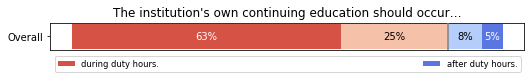

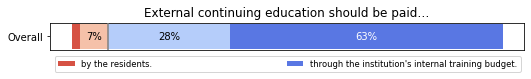

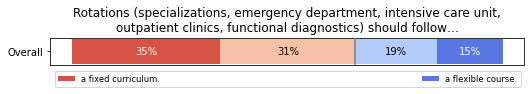

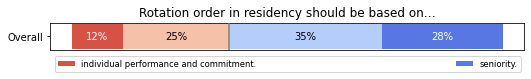

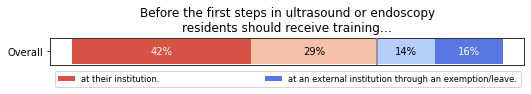

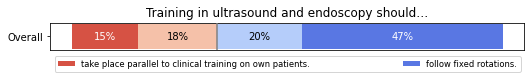

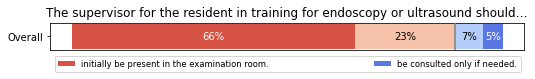

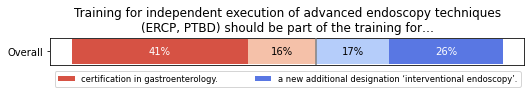

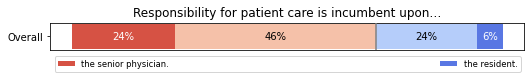

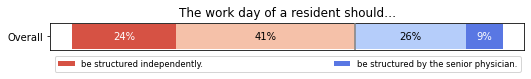

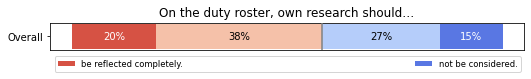

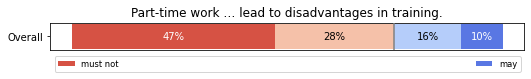

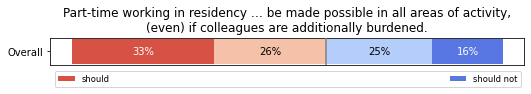

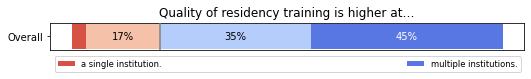

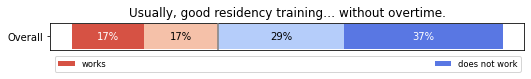

In [72]:
fmtlist=[".png",".svg"] 

for i,q in enumerate(q_list):
  op1 = surveydf[q].value_counts().sort_index().to_list()
  
  scale = q_scale_en[i].copy()  
  scale.insert(1,"")
  scale.insert(1,"")

  print(f"{q}:")
  fig, ax = likert([op1], g_en, scale)
  ax.set_title(q_long2_en[i])
  #fig.tight_layout()
  ax.legend(ncol=5, loc=(0.01,-0.8), fontsize='small', mode="expand") #bbox_to_anchor=(0, 1),
  
  for fmt in fmtlist:
    plt.savefig("output_data/overall_figs/"+q+fmt, bbox_inches="tight")


#### Position

W101_01


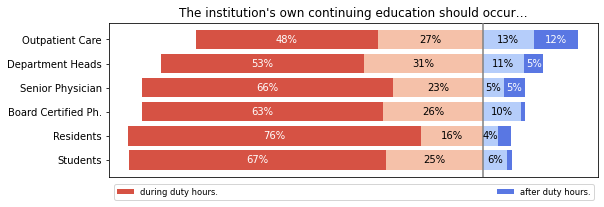


W102_01


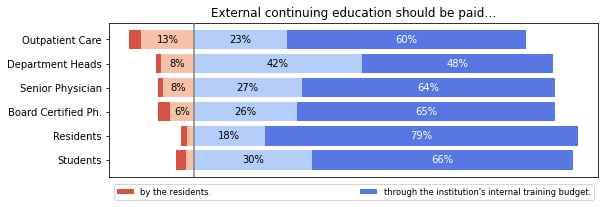


R101_01


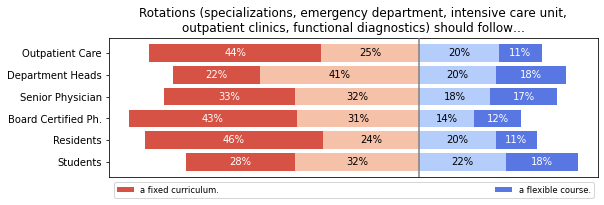


R102_01


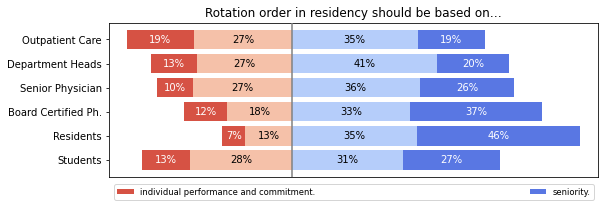


WI01_01


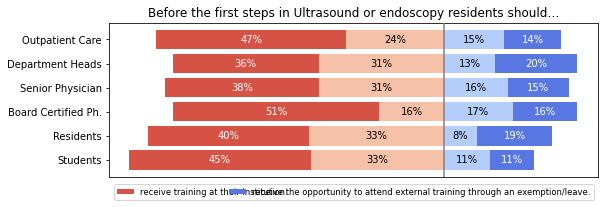


WI02_01


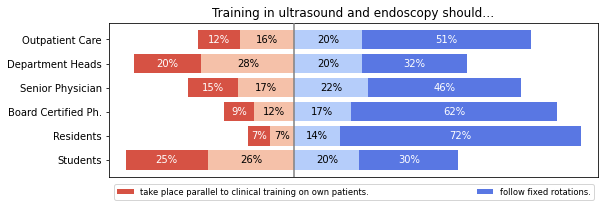


WI03_01


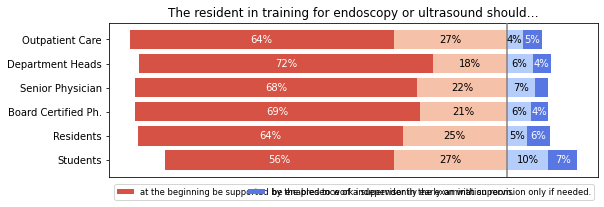


WI04_01


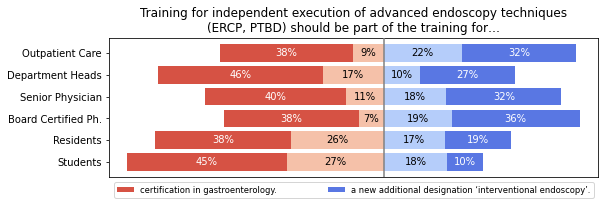


A101_01


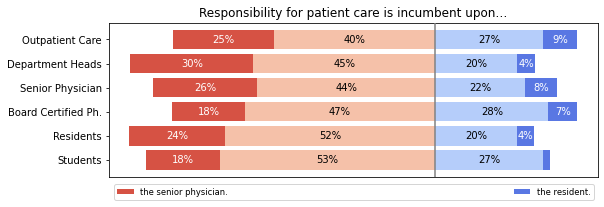


A102_01


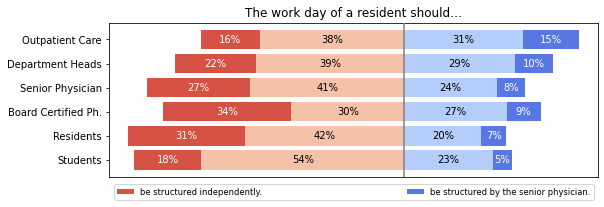


A103_01


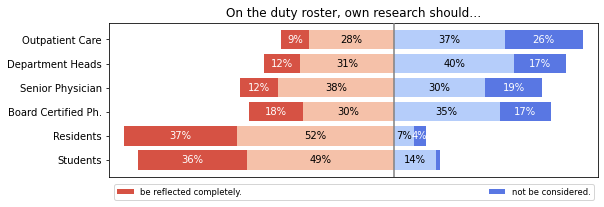


A104_01


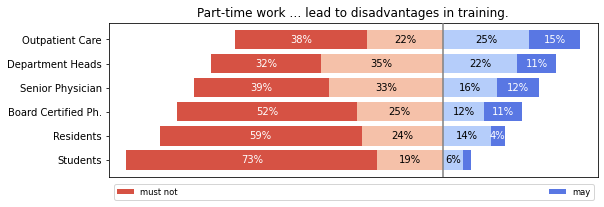


A105_01


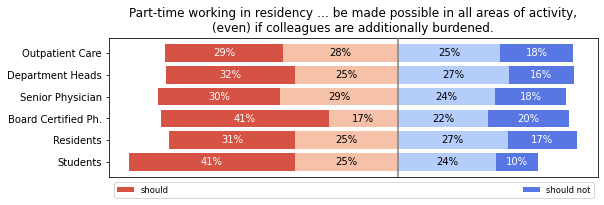


W201_01


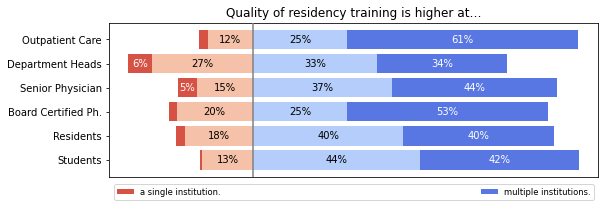


W202_01


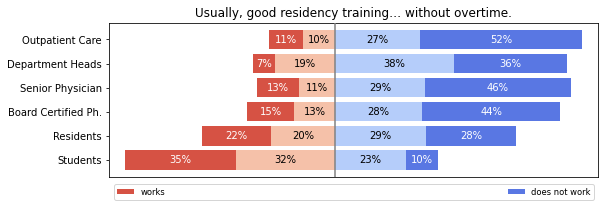

In [36]:
for i,q in enumerate(q_list):
  op1 = surveydf[q][surveydf.SD13 == 1].value_counts().sort_index().to_list()
  op2 = surveydf[q][surveydf.SD13 == 2].value_counts().sort_index().to_list()
  op3 = surveydf[q][surveydf.SD13 == 3].value_counts().sort_index().to_list()
  op4 = surveydf[q][surveydf.SD13 == 4].value_counts().sort_index().to_list()
  op5 = surveydf[q][surveydf.SD13 == 5].value_counts().sort_index().to_list()
  op6 = surveydf[q][surveydf.SD13 == 8].value_counts().sort_index().to_list()
  
  scale = q_scale_en[i].copy()  
  scale.insert(1,"")
  scale.insert(1,"")

  print(f"{q}")
  fig, ax = likert([op6, op1, op2, op3, op4, op5], pos_en, scale)
  ax.set_title(q_long2_en[i])
  ax.legend(ncol=2, loc=(0.01,-.15), fontsize='small', mode="expand") #bbox_to_anchor=(0, 1),
  fig.tight_layout()
  plt.show()
  print("")


#### Alter

W101_01:


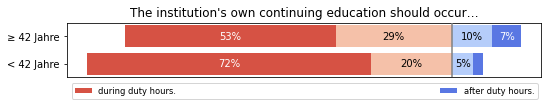


W102_01:


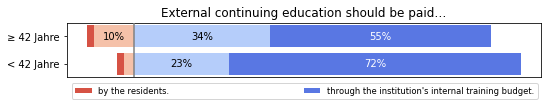


R101_01:


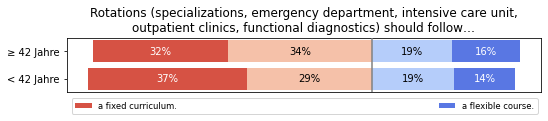


R102_01:


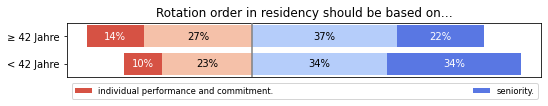


WI01_01:


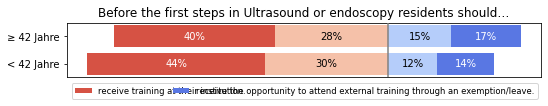


WI02_01:


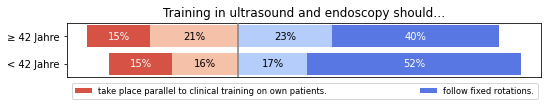


WI03_01:


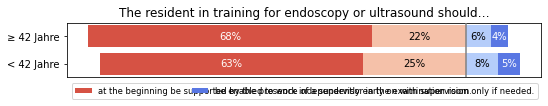


WI04_01:


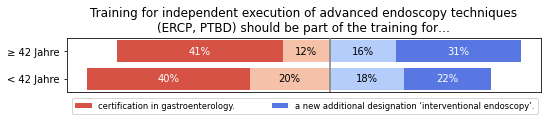


A101_01:


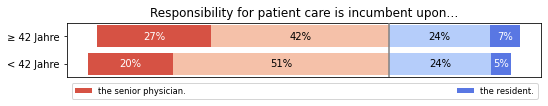


A102_01:


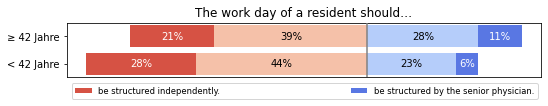


A103_01:


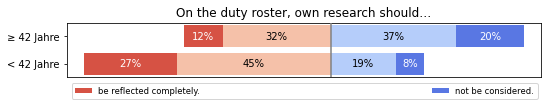


A104_01:


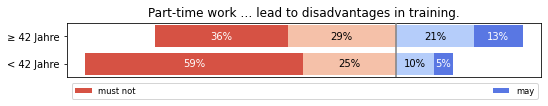


A105_01:


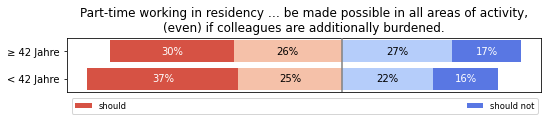


W201_01:


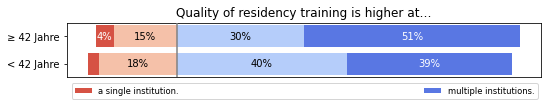


W202_01:


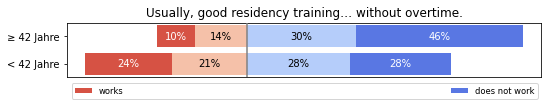

In [37]:
for i,q in enumerate(q_list):
  op1 = surveydf[q][surveydf["Age_cut"] == 2].value_counts().sort_index().to_list()
  op2 = surveydf[q][surveydf["Age_cut"] == 1].value_counts().sort_index().to_list()
  
  scale = q_scale_en[i].copy()  
  scale.insert(1,"")
  scale.insert(1,"")

  print(f"{q}:")
  fig, ax = likert([op1, op2], age_de, scale)
  ax.set_title(q_long2_en[i])
  ax.legend(ncol=5, loc=(0.01,-.4), fontsize='small', mode="expand") #bbox_to_anchor=(0, 1),
  #fig.tight_layout()
  plt.show()
  print("")

#### Geschlecht

W101_01:


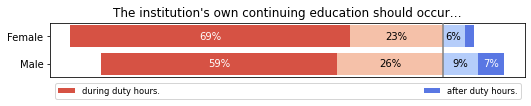

W102_01:


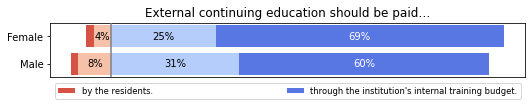

R101_01:


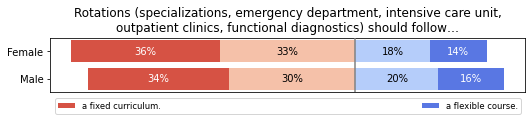

R102_01:


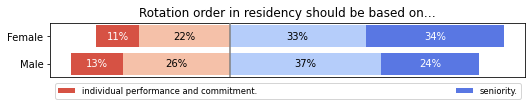

WI01_01:


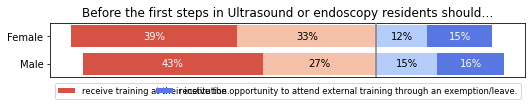

WI02_01:


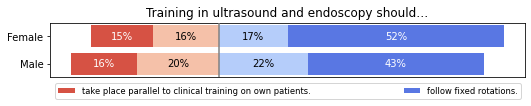

WI03_01:


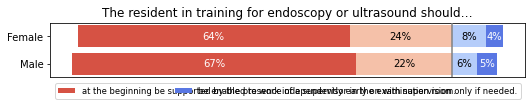

WI04_01:


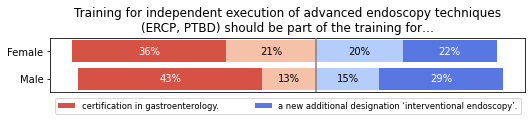

A101_01:


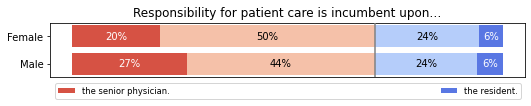

A102_01:


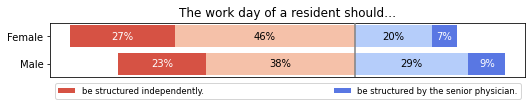

A103_01:


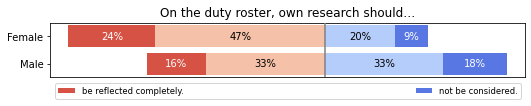

A104_01:


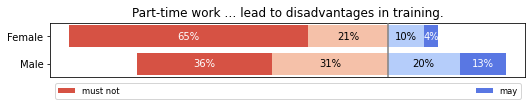

A105_01:


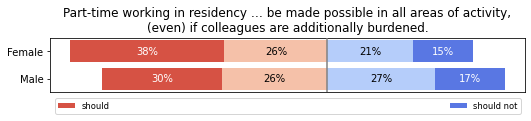

W201_01:


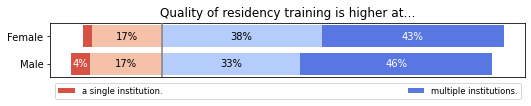

W202_01:


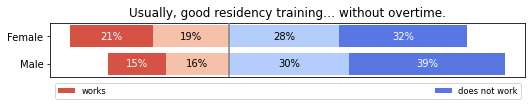

In [38]:
for i,q in enumerate(q_list):
  op1 = surveydf[q][surveydf.SD01 == 1].value_counts().sort_index().to_list()
  op2 = surveydf[q][surveydf.SD01 == 2].value_counts().sort_index().to_list()
  
  scale = q_scale_en[i].copy()  
  scale.insert(1,"")
  scale.insert(1,"")

  print(f"{q}:")
  fig, ax = likert([op1, op2], sex_en, scale)
  ax.set_title(q_long2_en[i])
  ax.legend(ncol=5, loc=(0.01,-.4), fontsize='small', mode="expand") #bbox_to_anchor=(0, 1),
  #fig.tight_layout()
  plt.show()

#### Versorgungstyp

W101_01:


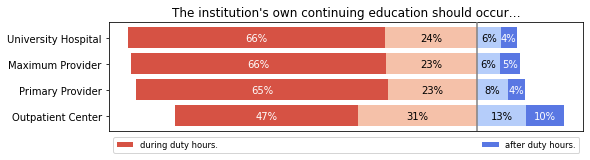

W102_01:


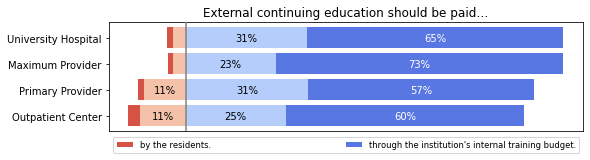

R101_01:


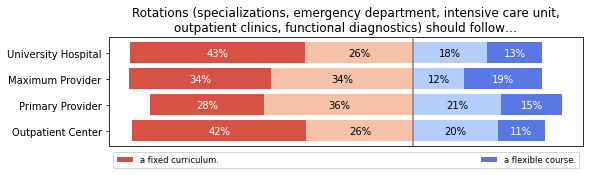

R102_01:


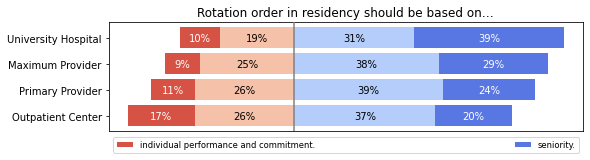

WI01_01:


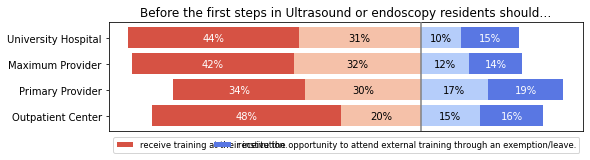

WI02_01:


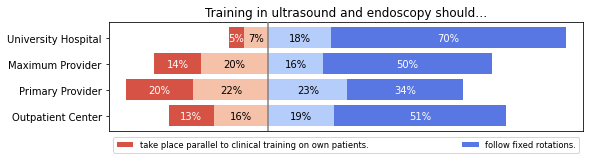

WI03_01:


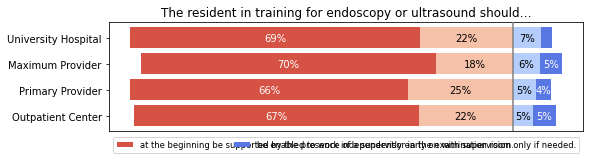

WI04_01:


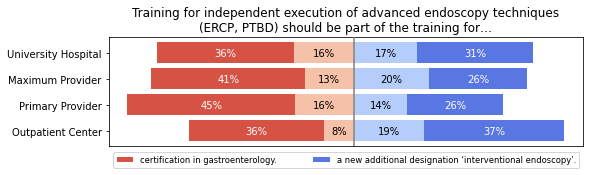

A101_01:


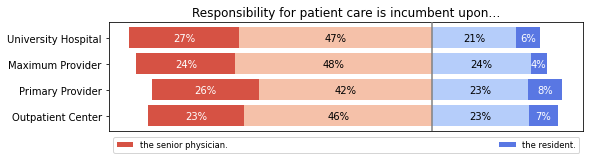

A102_01:


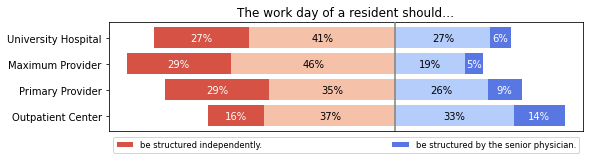

A103_01:


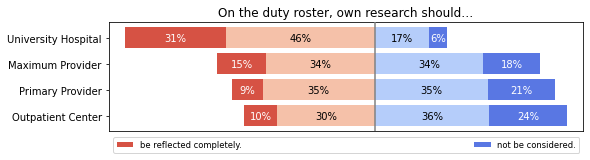

A104_01:


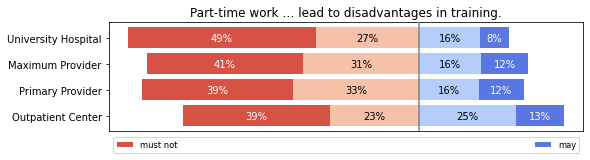

A105_01:


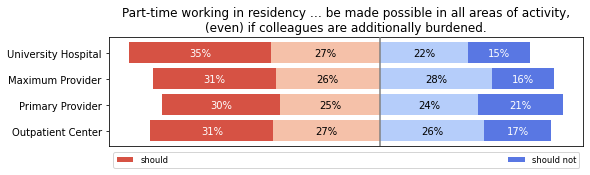

W201_01:


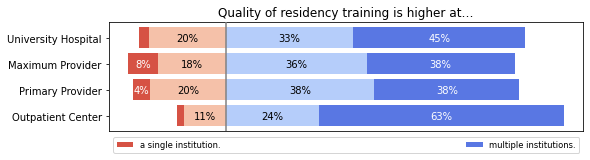

W202_01:


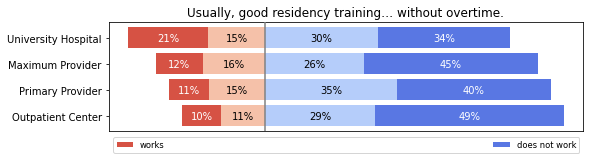

In [39]:
for i,q in enumerate(q_list):
  op1 = surveydf[q][surveydf.SD18 == 1].value_counts().sort_index().to_list()
  op2 = surveydf[q][surveydf.SD18 == 2].value_counts().sort_index().to_list()
  op3 = surveydf[q][surveydf.SD18 == 3].value_counts().sort_index().to_list()
  op4 = surveydf[q][surveydf.SD18 == 4].value_counts().sort_index().to_list()

  scale = q_scale_en[i].copy()  
  scale.insert(1,"")
  scale.insert(1,"")

  
  print(f"{q}:")
  fig, ax = likert([op1, op2, op3, op4], type_en, scale)
  ax.set_title(q_long2_en[i])
  ax.legend(ncol=5, loc=(0.01,-.2), fontsize='small', mode="expand") #bbox_to_anchor=(0, 1),
  #fig.tight_layout()
  plt.show()

#### Kinderstatus

W101_01:


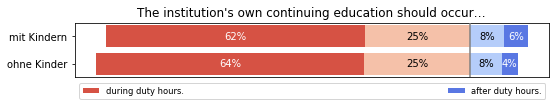

W102_01:


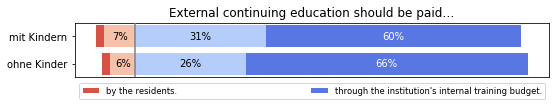

R101_01:


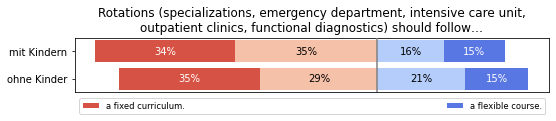

R102_01:


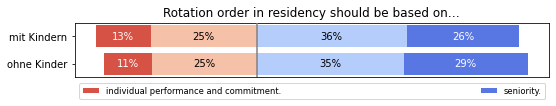

WI01_01:


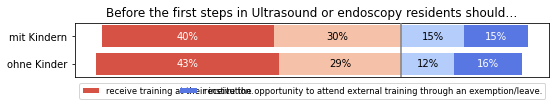

WI02_01:


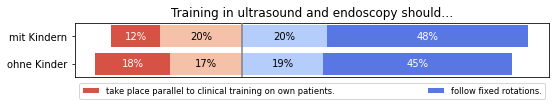

WI03_01:


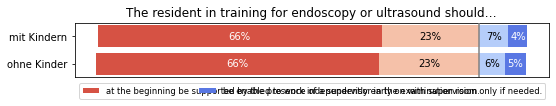

WI04_01:


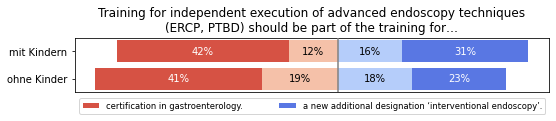

A101_01:


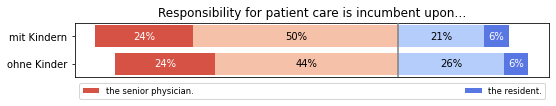

A102_01:


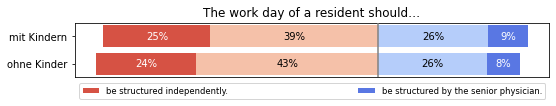

A103_01:


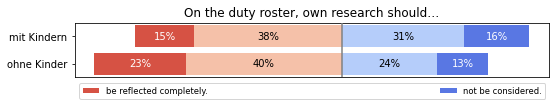

A104_01:


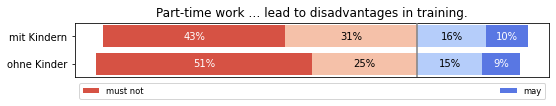

A105_01:


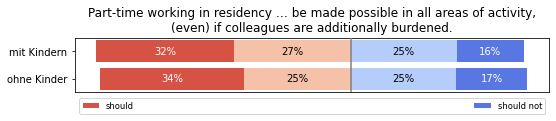

W201_01:


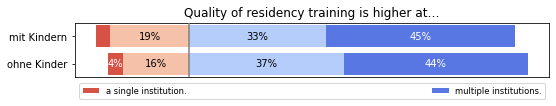

W202_01:


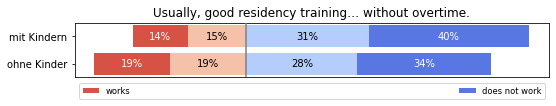

In [40]:
for i,q in enumerate(q_list):
  op1 = surveydf[q][surveydf.SD11 == 1].value_counts().sort_index().to_list()
  op2 = surveydf[q][surveydf.SD11 == 2].value_counts().sort_index().to_list()
  
  scale = q_scale_en[i].copy()  
  scale.insert(1,"")
  scale.insert(1,"")

  print(f"{q}:")
  fig, ax = likert([op1, op2,], child_de, scale)
  ax.set_title(q_long2_en[i])
  ax.legend(ncol=5, loc=(0.01,-.4), fontsize='small', mode="expand") #bbox_to_anchor=(0, 1),
  #fig.tight_layout()
  plt.show()

#### Arbeitszeitmodell

W101_01: 


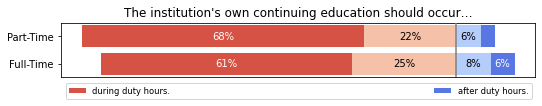

W102_01: 


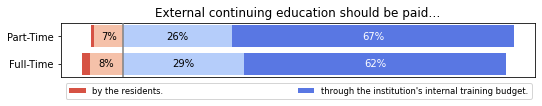

R101_01: 


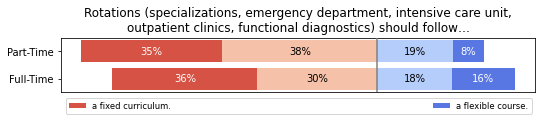

R102_01: 


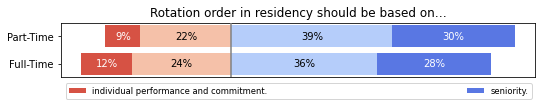

WI01_01: 


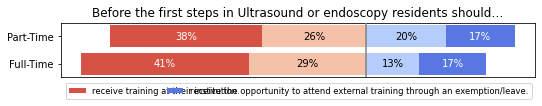

WI02_01: 


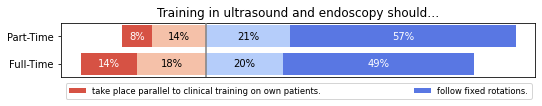

WI03_01: 


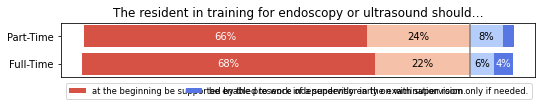

WI04_01: 


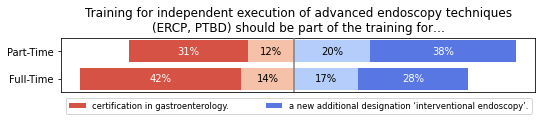

A101_01: 


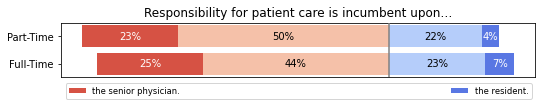

A102_01: 


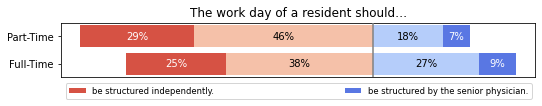

A103_01: 


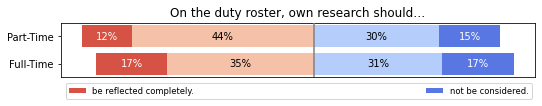

A104_01: 


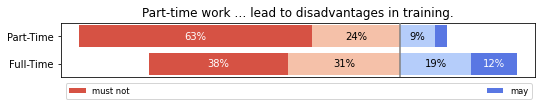

A105_01: 


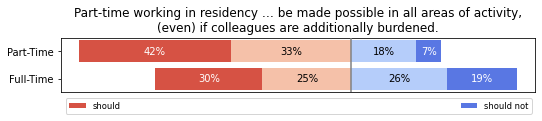

W201_01: 


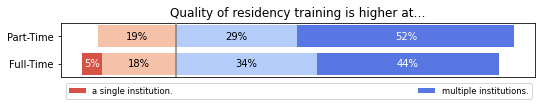

W202_01: 


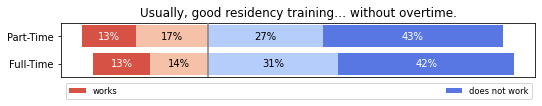

In [41]:
for i,q in enumerate(q_list):
  op1 = surveydf[q][surveydf.SD16 == 1].value_counts().sort_index().to_list()
  op2 = surveydf[q][surveydf.SD16 == 2].value_counts().sort_index().to_list()
  if len(op1) != len(op2): #Fehler abfangen bei keiner Antwort in einer Kategorie
    if len(op1) < len(op2):
      op1.insert(0,0)

  scale = q_scale_en[i].copy()  
  scale.insert(1,"")
  scale.insert(1,"")

  print(f"{q}: ")
  fig, ax = likert([op1, op2,], work_en, scale)
  ax.set_title(q_long2_en[i])
  ax.legend(ncol=5, loc=(0.01,-.4), fontsize='small', mode="expand") #bbox_to_anchor=(0, 1),
  #fig.tight_layout()
  plt.show()

### Figures for Paper

#### English Version

W201_01:


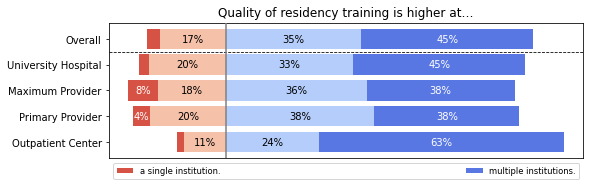

In [73]:
title= "Fig2"
fmtlist=[".png",".svg"] 
q = "W201_01"
i = q_list.index(q)

op0 = surveydf[q].value_counts().sort_index().to_list()
op1 = surveydf[q][surveydf.SD18 == 1].value_counts().sort_index().to_list()
op2 = surveydf[q][surveydf.SD18 == 2].value_counts().sort_index().to_list()
op3 = surveydf[q][surveydf.SD18 == 3].value_counts().sort_index().to_list()
op4 = surveydf[q][surveydf.SD18 == 4].value_counts().sort_index().to_list()
y_list = g_en+type_en

scale = q_scale_en[i].copy()  
scale.insert(1,"")
scale.insert(1,"")


print(f"{q}:")
fig, ax = likert([op0, op1, op2, op3, op4], y_list, scale)
ax.axhline(0.5, c="black", ls="--", linewidth=0.8)
ax.set_title(q_long2_en[i])
ax.legend(ncol=5, loc=(0.01,-.15), fontsize='small', mode="expand") #bbox_to_anchor=(0, 1),
#fig.tight_layout()
for fmt in fmtlist:
  plt.savefig("output_data/"+title+fmt, bbox_inches="tight")
plt.show()


W202_01: 


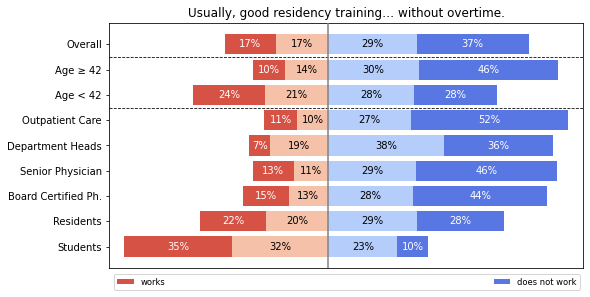

In [74]:
title="Fig3"
q = "W202_01"
i = q_list.index(q)

op0 = surveydf[q].value_counts().sort_index().to_list() #Gesamt
op1 = surveydf[q][surveydf.SD13 == 8].value_counts().sort_index().to_list()
op2 = surveydf[q][surveydf.SD13 == 1].value_counts().sort_index().to_list()
op3 = surveydf[q][surveydf.SD13 == 2].value_counts().sort_index().to_list()
op4 = surveydf[q][surveydf.SD13 == 3].value_counts().sort_index().to_list()
op5 = surveydf[q][surveydf.SD13 == 4].value_counts().sort_index().to_list()
op6 = surveydf[q][surveydf.SD13 == 5].value_counts().sort_index().to_list()
op7 = surveydf[q][surveydf["Age_cut"] == 2].value_counts().sort_index().to_list()
op8 = surveydf[q][surveydf["Age_cut"] == 1].value_counts().sort_index().to_list()

y_list = g_en+age_en+pos_en

scale = q_scale_en[i].copy()  
scale.insert(1,"")
scale.insert(1,"")

print(f"{q}: ")
fig, ax = likert([op0, op7, op8, op1, op2, op3, op4, op5, op6], y_list, scale)
ax.axhline(0.5, c="black", ls="--", linewidth=0.8)
ax.axhline(2.5, c="black", ls="--", linewidth=0.8)
ax.set_title(q_long2_en[i])
ax.legend(ncol=5, loc=(0.01,-.09), fontsize='small', mode="expand") #bbox_to_anchor=(0, 1),
#fig.tight_layout()
for fmt in fmtlist:
  plt.savefig("output_data/"+title+fmt, bbox_inches="tight")
plt.show()


A103_01: 


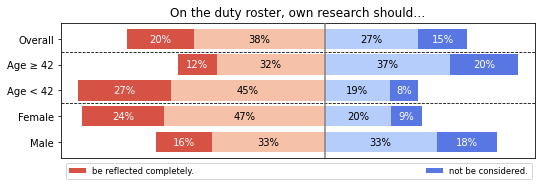

In [75]:
title= "Fig4"
q = "A103_01"
i = q_list.index(q)

op0 = surveydf[q].value_counts().sort_index().to_list() #Gesamt
op2 = surveydf[q][surveydf["Age_cut"] == 1].value_counts().sort_index().to_list()
op1 = surveydf[q][surveydf["Age_cut"] == 2].value_counts().sort_index().to_list()
op3 = surveydf[q][surveydf.SD01 == 1].value_counts().sort_index().to_list()
op4 = surveydf[q][surveydf.SD01 == 2].value_counts().sort_index().to_list()
  
y_list = g_en+age_en+sex_en

scale = q_scale_en[i].copy()  
scale.insert(1,"")
scale.insert(1,"")

print(f"{q}: ")
fig, ax = likert([op0, op1, op2, op3, op4], y_list, scale)
ax.axhline(0.5, c="black", ls="--", linewidth=0.8)
ax.axhline(2.5, c="black", ls="--", linewidth=0.8)
ax.set_title(q_long2_en[i])
ax.legend(ncol=5, loc=(0.01,-.15), fontsize='small', mode="expand") #bbox_to_anchor=(0, 1),
#fig.tight_layout()
for fmt in fmtlist:
  plt.savefig("output_data/"+title+fmt, bbox_inches="tight")
plt.show()

A104_01: 


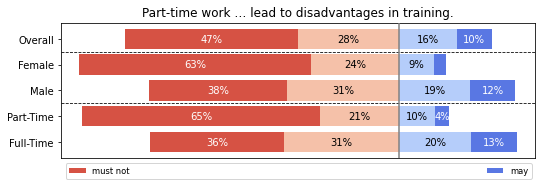

A105_01: 


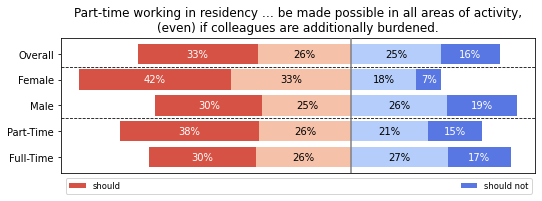

In [76]:
title="Fig5a"
q = "A104_01"
i = q_list.index(q)
op0 = surveydf[q].value_counts().sort_index().to_list() #Gesamt
op1 = surveydf[q][surveydf.SD16 == 1].value_counts().sort_index().to_list()
op2 = surveydf[q][surveydf.SD16 == 2].value_counts().sort_index().to_list()
op3 = surveydf[q][surveydf.SD01 == 1].value_counts().sort_index().to_list()
op4 = surveydf[q][surveydf.SD01 == 2].value_counts().sort_index().to_list()

y_list = g_en+sex_en+work_en

scale = q_scale_en[i].copy()  
scale.insert(1,"")
scale.insert(1,"")

print(f"{q}: ")
fig, ax = likert([op0, op1, op2, op3, op4], y_list, scale)
ax.axhline(0.5, c="black", ls="--", linewidth=0.8)
ax.axhline(2.5, c="black", ls="--", linewidth=0.8)
ax.set_title(q_long2_en[i])
ax.legend(ncol=5, loc=(0.01,-.15), fontsize='small', mode="expand") #bbox_to_anchor=(0, 1),
#fig.tight_layout()
for fmt in fmtlist:
  plt.savefig("output_data/"+title+fmt)
plt.show()

title = "Fig5b"
q = "A105_01"
i = q_list.index(q)
op0 = surveydf[q].value_counts().sort_index().to_list() #Gesamt
op1 = surveydf[q][surveydf.SD16 == 1].value_counts().sort_index().to_list()
op2 = surveydf[q][surveydf.SD16 == 2].value_counts().sort_index().to_list()
op3 = surveydf[q][surveydf.SD01 == 1].value_counts().sort_index().to_list()
op4 = surveydf[q][surveydf.SD01 == 2].value_counts().sort_index().to_list()

scale = q_scale_en[i].copy()  
scale.insert(1,"")
scale.insert(1,"")

print(f"{q}: ")
fig, ax = likert([op0, op1, op2, op3, op4], y_list, scale)
ax.axhline(0.5, c="black", ls="--", linewidth=0.8)
ax.axhline(2.5, c="black", ls="--", linewidth=0.8)
ax.set_title(q_long2_en[i])
ax.legend(ncol=5, loc=(0.01,-.15), fontsize='small', mode="expand") #bbox_to_anchor=(0, 1),
#fig.tight_layout()
for fmt in fmtlist:
  plt.savefig("output_data/"+title+fmt, bbox_inches="tight")
plt.show()

WI02_01: 


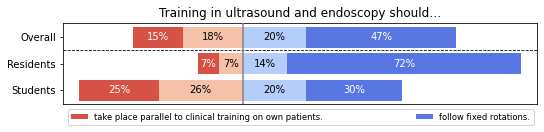

In [77]:
title="Fig6"
q = "WI02_01"
i = q_list.index(q)

op0 = surveydf[q].value_counts().sort_index().to_list() #Gesamt
op1 = surveydf[q][surveydf.SD13 == 4].value_counts().sort_index().to_list()
op2 = surveydf[q][surveydf.SD13 == 5].value_counts().sort_index().to_list()

y_list = g_en+pos_en[4:]

scale = q_scale_en[i].copy()  
scale.insert(1,"")
scale.insert(1,"")

print(f"{q}: ")
fig, ax = likert([op0, op1, op2], y_list, scale)
ax.axhline(0.5, c="black", ls="--", linewidth=0.8)
ax.set_title(q_long2_en[i])
ax.legend(ncol=5, loc=(0.01,-.25), fontsize='small', mode="expand") #bbox_to_anchor=(0, 1),
#fig.tight_layout()
for fmt in fmtlist:
  plt.savefig("output_data/"+title+fmt, bbox_inches="tight")
plt.show()


WI04_01: 


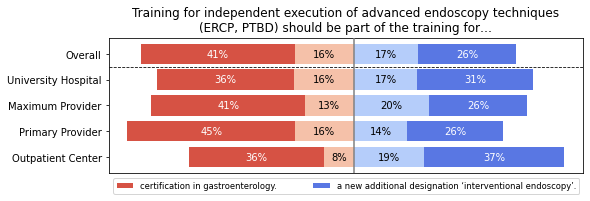

In [78]:
title= "Fig7"

q = "WI04_01"
i = q_list.index(q)

op1 = surveydf[q].value_counts().sort_index().to_list() #Gesamt
op2 = surveydf[q][surveydf.SD18 == 1].value_counts().sort_index().to_list()
op3 = surveydf[q][surveydf.SD18 == 2].value_counts().sort_index().to_list()
op4 = surveydf[q][surveydf.SD18 == 3].value_counts().sort_index().to_list()
op5 = surveydf[q][surveydf.SD18 == 4].value_counts().sort_index().to_list()

y_list = g_en+type_en

scale = q_scale_en[i].copy()  
scale.insert(1,"")
scale.insert(1,"")

print(f"{q}: ")
fig, ax = likert([op1, op2, op3, op4, op5], y_list, scale)
ax.axhline(0.5, c="black", ls="--", linewidth=0.8)
ax.set_title(q_long2_en[i])
ax.legend(ncol=5, loc=(0.01,-.15), fontsize='small', mode="expand") #bbox_to_anchor=(0, 1),
#fig.tight_layout()
for fmt in fmtlist:
  plt.savefig("output_data/"+title+fmt, bbox_inches="tight")
plt.show()

#### German version

W201_01:


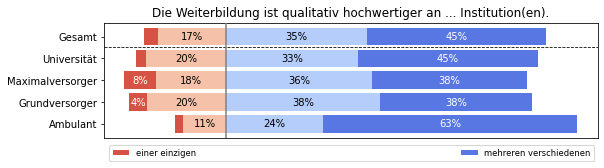

In [48]:
# Fig2
q = "W201_01"
i = q_list.index(q)

op0 = surveydf[q].value_counts().sort_index().to_list()
op1 = surveydf[q][surveydf.SD18 == 1].value_counts().sort_index().to_list()
op2 = surveydf[q][surveydf.SD18 == 2].value_counts().sort_index().to_list()
op3 = surveydf[q][surveydf.SD18 == 3].value_counts().sort_index().to_list()
op4 = surveydf[q][surveydf.SD18 == 4].value_counts().sort_index().to_list()
y_list = g_de+type_de

scale = q_scale_de[i].copy()  
scale.insert(1,"")
scale.insert(1,"")


print(f"{q}:")
fig, ax = likert([op0, op1, op2, op3, op4], y_list, scale)
ax.axhline(0.5, c="black", ls="--", linewidth=0.8)
ax.set_title(q_long2_de[i])
ax.legend(ncol=5, loc=(0.01,-.2), fontsize='small', mode="expand") #bbox_to_anchor=(0, 1),
fig.tight_layout()
plt.show()

W202_01: 


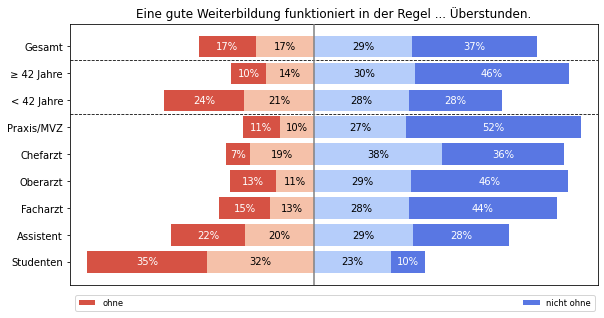

In [49]:
#Fig3
q = "W202_01"
i = q_list.index(q)

op0 = surveydf[q].value_counts().sort_index().to_list() #Gesamt
op1 = surveydf[q][surveydf.SD13 == 8].value_counts().sort_index().to_list()
op2 = surveydf[q][surveydf.SD13 == 1].value_counts().sort_index().to_list()
op3 = surveydf[q][surveydf.SD13 == 2].value_counts().sort_index().to_list()
op4 = surveydf[q][surveydf.SD13 == 3].value_counts().sort_index().to_list()
op5 = surveydf[q][surveydf.SD13 == 4].value_counts().sort_index().to_list()
op6 = surveydf[q][surveydf.SD13 == 5].value_counts().sort_index().to_list()
op7 = surveydf[q][surveydf["Age_cut"] == 2].value_counts().sort_index().to_list()
op8 = surveydf[q][surveydf["Age_cut"] == 1].value_counts().sort_index().to_list()

y_list = g_de+age_de+pos_de

scale = q_scale_de[i].copy()  
scale.insert(1,"")
scale.insert(1,"")

print(f"{q}: ")
fig, ax = likert([op0, op7, op8, op1, op2, op3, op4, op5, op6], y_list, scale)
ax.axhline(0.5, c="black", ls="--", linewidth=0.8)
ax.axhline(2.5, c="black", ls="--", linewidth=0.8)
ax.set_title(q_long2_de[i])
ax.legend(ncol=5, loc=(0.01,-.1), fontsize='small', mode="expand") #bbox_to_anchor=(0, 1),
fig.tight_layout()
plt.show()


A103_01: 


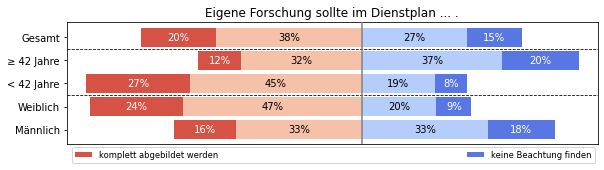

In [50]:
# FIg 4
q = "A103_01"
i = q_list.index(q)

op0 = surveydf[q].value_counts().sort_index().to_list() #Gesamt
op2 = surveydf[q][surveydf["Age_cut"] == 1].value_counts().sort_index().to_list()
op1 = surveydf[q][surveydf["Age_cut"] == 2].value_counts().sort_index().to_list()
op3 = surveydf[q][surveydf.SD01 == 1].value_counts().sort_index().to_list()
op4 = surveydf[q][surveydf.SD01 == 2].value_counts().sort_index().to_list()
  
y_list = g_de+age_de+sex_de

scale = q_scale_de[i].copy()  
scale.insert(1,"")
scale.insert(1,"")

print(f"{q}: ")
fig, ax = likert([op0, op1, op2, op3, op4], y_list, scale)
ax.axhline(0.5, c="black", ls="--", linewidth=0.8)
ax.axhline(2.5, c="black", ls="--", linewidth=0.8)
ax.set_title(q_long2_de[i])
ax.legend(ncol=5, loc=(0.01,-.15), fontsize='small', mode="expand") #bbox_to_anchor=(0, 1),
fig.tight_layout()
plt.show()

A104_01: 


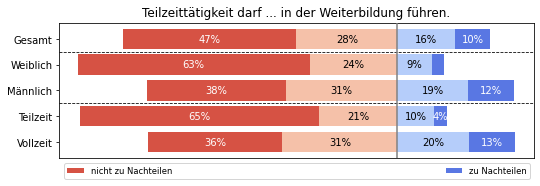

A105_01: 


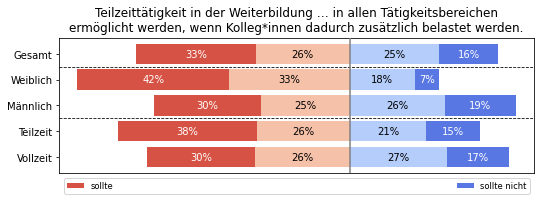

In [51]:
#Fig 5
q = "A104_01"
i = q_list.index(q)
op0 = surveydf[q].value_counts().sort_index().to_list() #Gesamt
op1 = surveydf[q][surveydf.SD16 == 1].value_counts().sort_index().to_list()
op2 = surveydf[q][surveydf.SD16 == 2].value_counts().sort_index().to_list()
op3 = surveydf[q][surveydf.SD01 == 1].value_counts().sort_index().to_list()
op4 = surveydf[q][surveydf.SD01 == 2].value_counts().sort_index().to_list()

y_list = g_de+sex_de+work_de

scale = q_scale_de[i].copy()  
scale.insert(1,"")
scale.insert(1,"")

print(f"{q}: ")
fig, ax = likert([op0, op1, op2, op3, op4], y_list, scale)
ax.axhline(0.5, c="black", ls="--", linewidth=0.8)
ax.axhline(2.5, c="black", ls="--", linewidth=0.8)
ax.set_title(q_long2_de[i])
ax.legend(ncol=5, loc=(0.01,-.15), fontsize='small', mode="expand") #bbox_to_anchor=(0, 1),
#fig.tight_layout()
plt.show()

q = "A105_01"
i = q_list.index(q)
op0 = surveydf[q].value_counts().sort_index().to_list() #Gesamt
op1 = surveydf[q][surveydf.SD16 == 1].value_counts().sort_index().to_list()
op2 = surveydf[q][surveydf.SD16 == 2].value_counts().sort_index().to_list()
op3 = surveydf[q][surveydf.SD01 == 1].value_counts().sort_index().to_list()
op4 = surveydf[q][surveydf.SD01 == 2].value_counts().sort_index().to_list()

scale = q_scale_de[i].copy()  
scale.insert(1,"")
scale.insert(1,"")

print(f"{q}: ")
fig, ax = likert([op0, op1, op2, op3, op4], y_list, scale)
ax.axhline(0.5, c="black", ls="--", linewidth=0.8)
ax.axhline(2.5, c="black", ls="--", linewidth=0.8)
ax.set_title(q_long2_de[i])
ax.legend(ncol=5, loc=(0.01,-.15), fontsize='small', mode="expand") #bbox_to_anchor=(0, 1),
#fig.tight_layout()
plt.show()

WI02_01: 


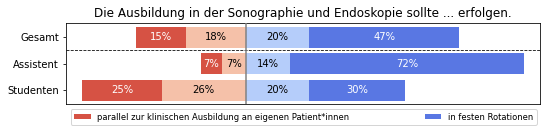

In [52]:
#Fig 6
q = "WI02_01"
i = q_list.index(q)

op0 = surveydf[q].value_counts().sort_index().to_list() #Gesamt
op1 = surveydf[q][surveydf.SD13 == 4].value_counts().sort_index().to_list()
op2 = surveydf[q][surveydf.SD13 == 5].value_counts().sort_index().to_list()

y_list = g_de+pos_de[4:]

scale = q_scale_de[i].copy()  
scale.insert(1,"")
scale.insert(1,"")

print(f"{q}: ")
fig, ax = likert([op0, op1, op2], y_list, scale)
ax.axhline(0.5, c="black", ls="--", linewidth=0.8)
ax.set_title(q_long2_de[i])
ax.legend(ncol=5, loc=(0.01,-.25), fontsize='small', mode="expand") #bbox_to_anchor=(0, 1),
#fig.tight_layout()
plt.show()


WI04_01: 


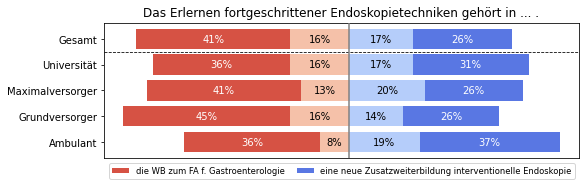

In [53]:
# Fig 7

q = "WI04_01"
i = q_list.index(q)

op1 = surveydf[q].value_counts().sort_index().to_list() #Gesamt
op2 = surveydf[q][surveydf.SD18 == 1].value_counts().sort_index().to_list()
op3 = surveydf[q][surveydf.SD18 == 2].value_counts().sort_index().to_list()
op4 = surveydf[q][surveydf.SD18 == 3].value_counts().sort_index().to_list()
op5 = surveydf[q][surveydf.SD18 == 4].value_counts().sort_index().to_list()

y_list = g_de+type_de

scale = q_scale_de[i].copy()  
scale.insert(1,"")
scale.insert(1,"")

print(f"{q}: ")
fig, ax = likert([op1, op2, op3, op4, op5], y_list, scale)
ax.axhline(0.5, c="black", ls="--", linewidth=0.8)
ax.set_title(q_long2_de[i])
ax.legend(ncol=5, loc=(0.01,-.15), fontsize='small', mode="expand") #bbox_to_anchor=(0, 1),
#fig.tight_layout()
plt.show()

## Misc

In [54]:
"""
#Alter Datenzugriff
!mkdir input_data
#Hochladen
surveydf = pd.read_excel("input_data/data_JuGa_final.xlsx")
surveydf
"""

'\n#Alter Datenzugriff\n!mkdir input_data\n#Hochladen\nsurveydf = pd.read_excel("input_data/data_JuGa_final.xlsx")\nsurveydf\n'

----
**_Hinweis_**

Bitte im Ordner "input_data" "data_JuGa_final.xslx" hochladen, damit das Skript läuft.

-----

---
**CAVE**: 
Raw data from the supplement ("data_JuGa_final.xslx") must be uploaded into the "input_data" folder after the first code block was run.
In diesem Abschnitt muss die Rohdatendatei hochgeladen werden.

---